In [3]:
# Imports

import numpy as np
import numpy.linalg as la
import scipy.linalg.interpolative as sli
import matplotlib as mp
import matplotlib.cm as cm
import scipy

from scipy.misc import imresize
from scipy.fftpack import dct
from scipy.ndimage import interpolation

# if available import pylab (from matlibplot)
try:
    import matplotlib.pylab as plt
except ImportError:
    pass

In [4]:
import scipy.io.wavfile as wavfile
from IPython.display import Audio

In [5]:
first_half = lambda l: l[1:(1+len(l)/2)]
power = lambda z: np.absolute(z)

def frequencies(f, Fs):
    x = np.linspace(0, Fs, len(f), endpoint=False)
    x[len(f)/2:] -= Fs # second half starts at lowest negative frequency
    return x

def freqcompare(y, Fs):
    powerfft = power(np.fft.fft(y))
    x = frequencies(y, Fs)
    plt.subplot(1,2,1)
    plt.plot(np.arange(len(y))*1./Fs, y)
    plt.xlim(0,len(y)*1./Fs)
    plt.ylim(min(y)-1,max(y)+1)
    plt.subplot(1,2,2)
    plt.plot(x, powerfft)
    plt.xlim(min(x)-1,max(x)+1)
    plt.ylim(0,max(powerfft)+1)
    plt.show()

nearest_2power = lambda x: int(np.log2(x))

In [6]:
semitone = 2.**(1./12.)

def genNotes(octaves):
    # instead of multiplying by 2^(1/12) over and over, we reduce drift/error
    # by creating all the C tones, which are multiples of 2 away from each other
    c_freqs = np.array([130.81*(2**i) for i in range(octaves)])
    ratios = np.array([semitone**i for i in range(12)]) 
    return np.dot(c_freqs[:, None], ratios[None, :]).flatten() # indexing with "None" adds an empty dimension

notes = genNotes(octaves=5)

# add an extra note below and above, so the dividing lines for the first and last C get computed properly
notes_expanded = np.concatenate(([notes[0]/semitone], notes, [notes[-1]*semitone]))
dividers = (notes_expanded[:-1]+notes_expanded[1:])/2. # calc dividing lines using average
dividers = np.array([dividers[:-1],dividers[1:]]).T # make each element a pair of dividing lines

def note_power(power, Fs):
    x = frequencies(power, Fs)
    return np.array([max(power[(x >= left) & (x < right)]) for left,right in dividers])


In [7]:
# some tests to make sure my key is correct

tone = lambda freq, t=8., Fs=44100., angle=0.: np.cos(freq*2*np.pi*np.linspace(0, t, Fs*t, endpoint=False)+angle)

def playFreq(freq):
    t = 8. # 8 seconds
    Fs = 44100.
    return Audio(tone(freq,t,Fs), rate=Fs)


## Multiple Instruments

In [19]:
Fs, rawsakae = wavfile.read('sakaeinaction.wav')

print Fs # make sure Fs matches all previous Fs
print rawsakae.shape

44100
(8353916L, 2L)


In [20]:
# reformat the data to match output of octave's wavread (divide by INT_MAX to normalize amplitude to [-1,1])
rawsakae1 = (rawsakae*1.)/np.iinfo(rawsakae[0][0]).max
rawsakae1 = rawsakae1[:,0] # only keep the first track

sakae = rawsakae1[:2**nearest_2power(rawsakae1.shape[0])] # clip end to make data length a power of 2

In [21]:
sakae_beginning = sakae[:2**18]

In [22]:
sakae_offset = sakae[44100:]

In [23]:
class Sampler:
    def __init__(self, song, N, offset=0, Fs=44100.):
        self.song = song
        self.N = N # sample size
        self.Fs = Fs
        self.w1_vec = np.fft.fft(np.arange(N) == 1) # extract the [1 w w^2 w^3...] vector using an fft of [0 1 0 0 0 ...]
        self.wN_vec = np.fft.fft(np.arange(N) == N-1) # extract the [1 w^(N-1) w^2(N-1) ...] using an fft of [0 0 0 ... 0 1]
        self.frequencies = frequencies(np.arange(self.N), self.Fs)
        self.reset(offset)
    
    def next(self):
        if (len(self.song) <= self.offset+self.N):
            return np.zeros(self.N) # song finished, just return zeros
        
        old_datum = self.song[self.offset]
        new_datum = self.song[self.offset+self.N]
        self.offset += 1
        self.dft = (self.dft-old_datum)/self.w1_vec + new_datum*self.wN_vec
        return self.dft
        
    def reset(self, offset=0):
        self.offset = offset
        self.dft = np.fft.fft(self.song[self.offset:self.offset+self.N])
        return self.dft
    
    def current_sample(self):
        return self.song[self.offset:self.offset+self.N]

In [24]:
sakaeSampler = Sampler(sakae_offset, 1024)

In [31]:
class DominantFrequencySampler(Sampler):
    def getDominantFrequencies(self, n=5):
        power_half = power(first_half(self.dft)[:-1]) # exclude the last frequency, because it *could* be the lowest negative freq
        top_powers = np.argpartition(power_half, -n)[-n:] # use argpartition to get indices of top n frequencies
        top_powers = top_powers[np.argsort(power_half[top_powers])][::-1] # sort the top frequency indices in descending order
        self.top_freqs = self.frequencies[top_powers+1] # add 1 because power_half starts at index 1 (not 0)
        self.top_magnitudes = power_half[top_powers]
        self.top_phases = np.angle(self.dft[top_powers+1])
        return (self.top_freqs, self.top_magnitudes, self.top_phases)

In [32]:
lowSampler = DominantFrequencySampler(sakae_offset, Fs/20)

In [33]:
sakae5Secs = sakae[:44100*5]

lowSampler2 = DominantFrequencySampler(sakae5Secs, Fs/20) # only look at first 5 seconds

In [34]:
oneSec = Fs # number of frames for 1 second

In [36]:
indx1760 = np.nonzero((lowSampler2.frequencies > 1755) & (lowSampler2.frequencies < 1765))[0][0] # index of freq ~880

A6PowerOverTime = power([lowSampler2.next()[indx1760] for i in range(oneSec*2)])

In [37]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n-1:] / n


### Shape

let's find where the power of A6 is the highest, and then extract the frequency shape

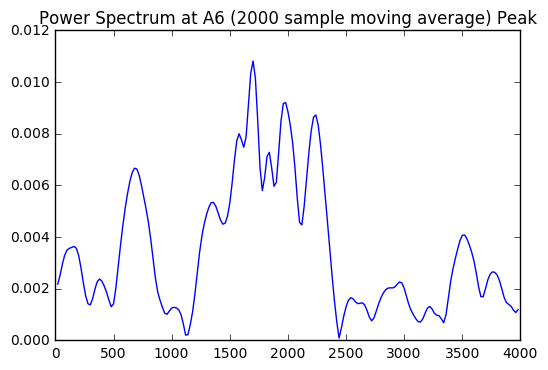

In [38]:
# use moving average, that looked the best

averaged = moving_average(A6PowerOverTime, n=2000)

maxA6Index = np.argmax(averaged)-2000/2 # remember to shift it back by n/2

lowSampler2.reset(offset=maxA6Index)

frequencyRange = np.nonzero((lowSampler2.frequencies > 0) & (lowSampler2.frequencies < 4000))

plt.plot(lowSampler2.frequencies[frequencyRange],power(lowSampler2.dft[frequencyRange]))
plt.title("Power Spectrum at A6 (2000 sample moving average) Peak")
plt.show()

ooh, see, thats the problem with moving average. Because the max index shifted around -900 (shown earlier), when we shifted
back by 1000, we overshot and now we're looking at datapoints before the spike. Let's compromise and use a moving average
of 200 instead of 2000

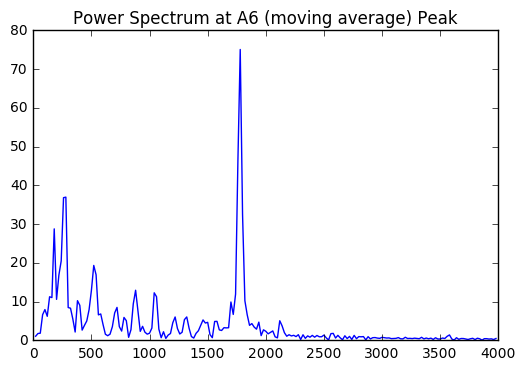

In [545]:
averaged = moving_average(A6PowerOverTime, n=200)

maxA6Index = np.argmax(averaged)-200/2 # remember to shift it back by n/2

lowSampler2.reset(offset=maxA6Index)

plt.plot(lowSampler2.frequencies[frequencyRange],power(lowSampler2.dft[frequencyRange]))
plt.title("Power Spectrum at A6 (moving average) Peak")
plt.show()

Much better. Now let's try averaging the power spectrums around this point

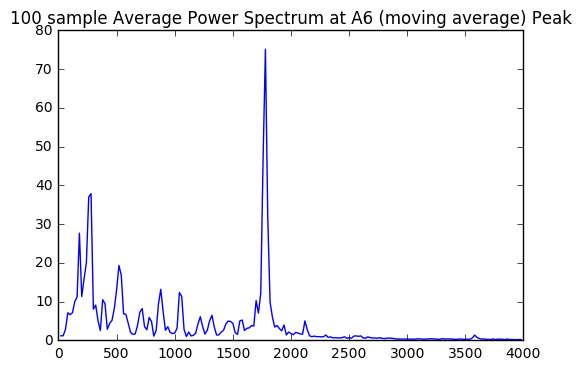

In [546]:
lowSampler2.reset(offset=maxA6Index-50)
averagedShape = np.mean([power(lowSampler2.next()[frequencyRange]) for i in range(100)], axis=0)

plt.plot(lowSampler2.frequencies[frequencyRange], averagedShape)
plt.title("100 sample Average Power Spectrum at A6 (moving average) Peak")
plt.show()

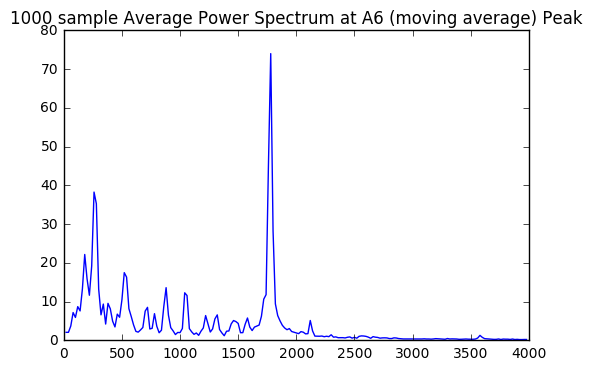

In [547]:
lowSampler2.reset(offset=maxA6Index-500)
averagedShape = np.mean([power(lowSampler2.next()[frequencyRange]) for i in range(1000)], axis=0)

plt.plot(lowSampler2.frequencies[frequencyRange], averagedShape)
plt.title("1000 sample Average Power Spectrum at A6 (moving average) Peak")
plt.show()

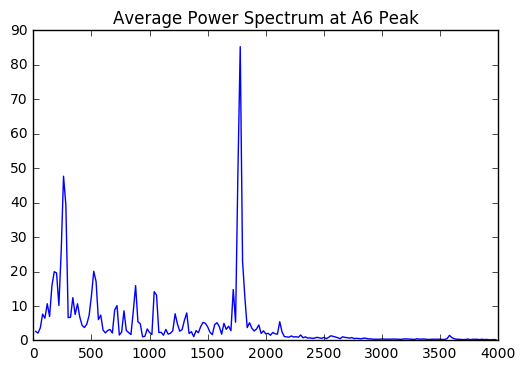

In [541]:
# lets try finding the max point without the moving averaging this time:

maxA6Index = np.argmax(A6PowerOverTime)

lowSampler2.reset(offset=maxA6Index-50)
averagedShape = np.mean([power(lowSampler2.next()[frequencyRange]) for i in range(100)], axis=0)

plt.plot(lowSampler2.frequencies[frequencyRange],averagedShape)
plt.title("Average Power Spectrum at A6 Peak")
plt.show()


The next piano note happens around 1.4 seconds, and is an E6 (1319 Hz)

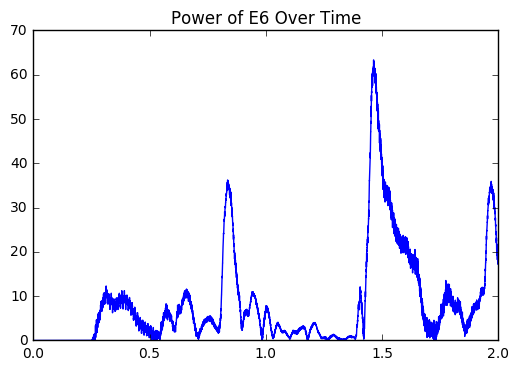

In [540]:
# for all notes, use the low sampler from now on

lowSampler2.reset()

indx1319 = np.nonzero((lowSampler2.frequencies > 1315) & (lowSampler2.frequencies < 1325))[0][0] # index of freq ~1319

E6PowerOverTime = power([lowSampler2.next()[indx1319] for i in range(oneSec*2)])

plt.plot(np.linspace(0,2,oneSec*2,endpoint=False),E6PowerOverTime)
plt.title("Power of E6 Over Time")
plt.show()

note the spike at ~0.8 seconds, this is probably because the violin is playing E5

Find the max (without the moving average), and then find the average shape of the frequencies at that max

max E6 power at 1.46365079365 seconds


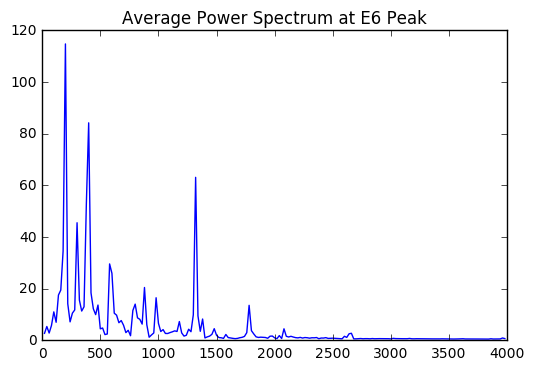

In [539]:
maxE6Index = np.argmax(E6PowerOverTime)

print "max E6 power at " + str(maxE6Index*1./Fs) + " seconds"

lowSampler2.reset(offset=maxE6Index-5)
averagedShape = np.mean([power(lowSampler2.next()[frequencyRange]) for i in range(10)], axis=0)

plt.plot(lowSampler2.frequencies[frequencyRange], averagedShape)
plt.title("Average Power Spectrum at E6 Peak")
plt.show()

hmmm, clearly other frequencies going on here...we could see that in the spectrogram earlier too, and we could hear it in the music

In [513]:
def more_efficient_eigenfaces(Sample, k):
    sbar = np.mean(Sample, 0) # average image (in a vector)
    
    M = np.dot(np.ones((len(Sample), 1)), [sbar]) # create s copies of the average image
    X = Sample-M # subtract each sample image by a copy of the average image
    [U_k, S_k, V_k] = sli.svd(np.cov(X.T), k) # find the covariance for each pixel across all samples (k-th order)
    
    C = np.dot(X, U_k) # each row is each face's eigencoefficients representing "coordinates in face space"
    
    return (Sample, sbar, M, U_k, S_k)

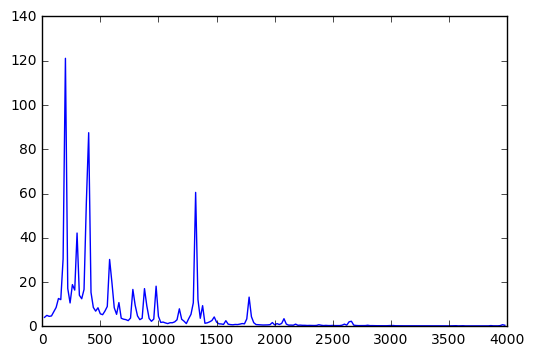

In [514]:
lowSampler2.reset(offset=maxE6Index-5)
test = np.mean([power(lowSampler2.next()[frequencyRange]) for i in range(400)], axis=0)

plt.plot(lowSampler2.frequencies[frequencyRange], test)

plt.show()


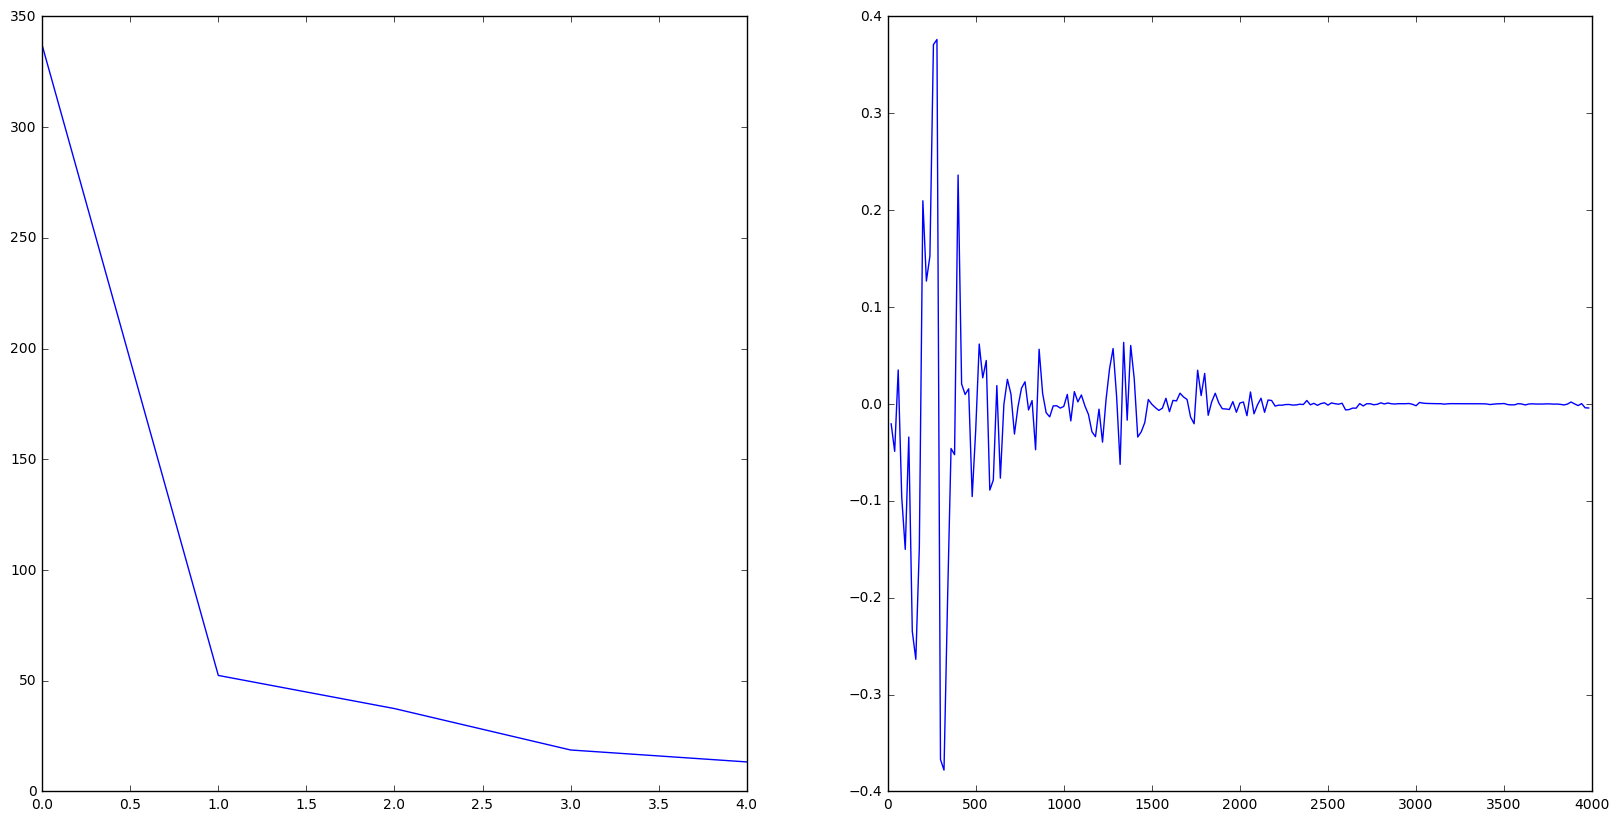

In [520]:
lowSampler2.reset(offset=maxE6Index-5)
test = np.array([power(lowSampler2.next()[frequencyRange]) for i in range(400)])

_, _, _, U_k, S_k = more_efficient_eigenfaces(test, 5)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(S_k)
plt.subplot(1,2,2)
plt.plot(lowSampler2.frequencies[frequencyRange], U_k[:,0])
plt.show()

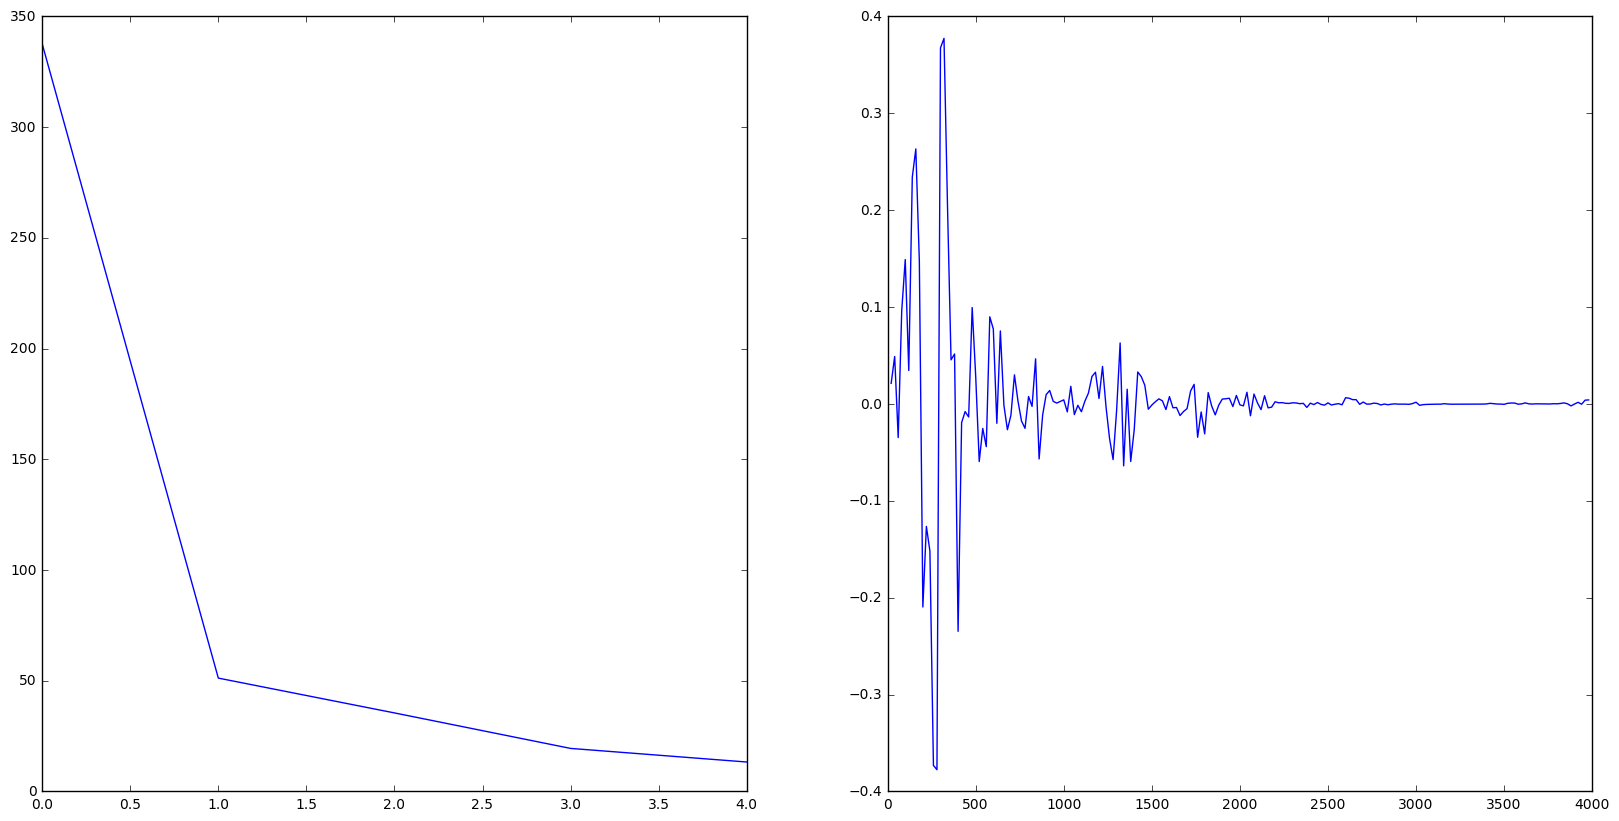

In [521]:
# lets try without normalizing during PCA

def more_efficient_eigenfaces2(Sample, k):
    [U_k, S_k, V_k] = sli.svd(np.cov(Sample.T), k) # find the covariance for each pixel across all samples (k-th order)
    return (U_k, S_k)

U_k, S_k = more_efficient_eigenfaces2(test, 5)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(S_k)
plt.subplot(1,2,2)
plt.plot(lowSampler2.frequencies[frequencyRange], U_k[:,0])
plt.show()

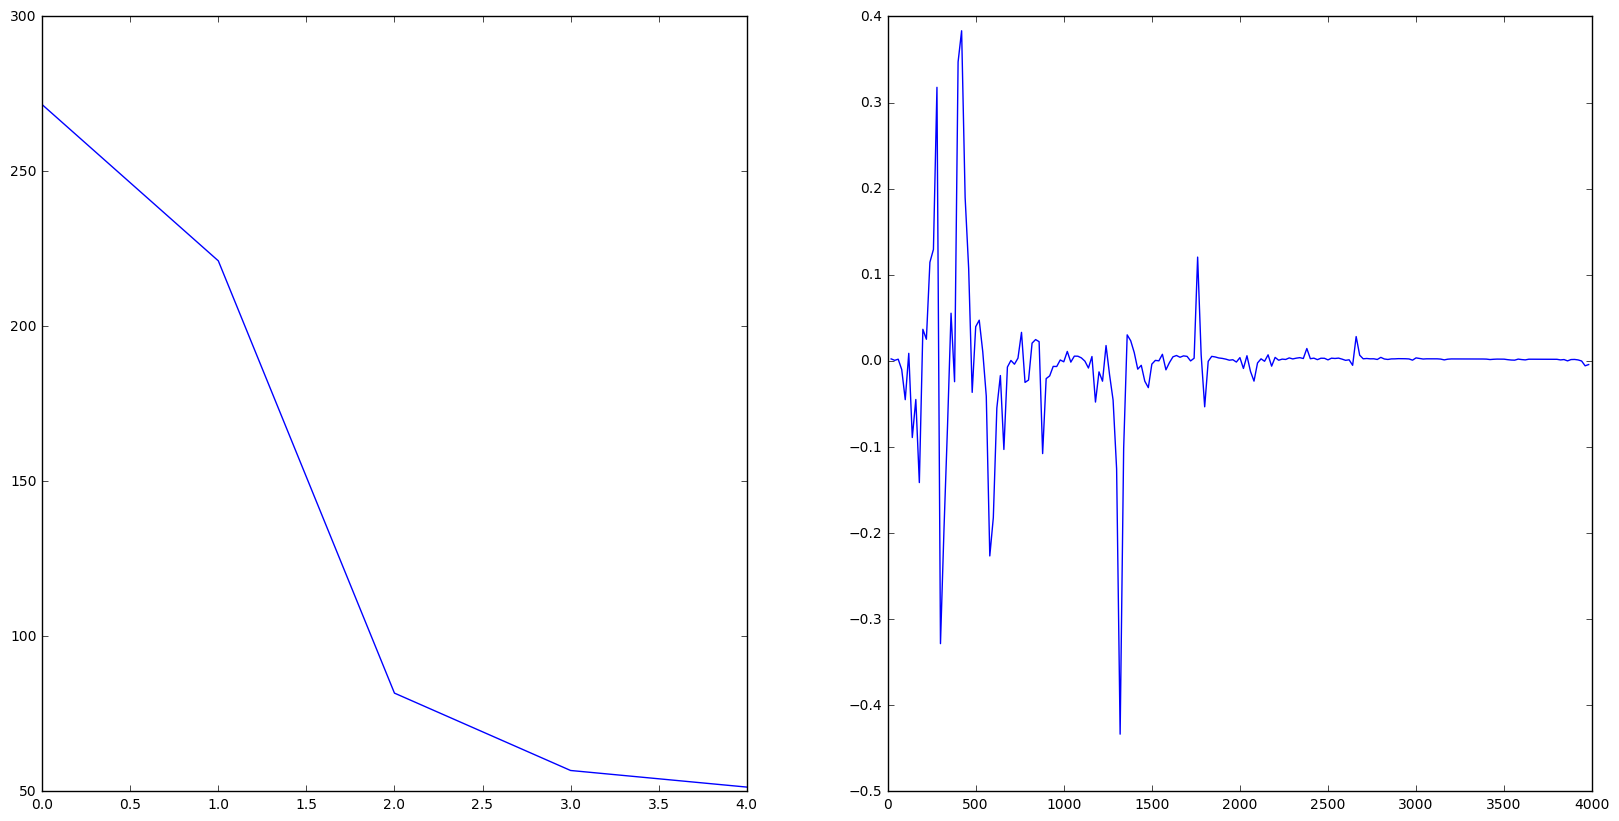

In [525]:
lowSampler2.reset(offset=maxE6Index-5)
test = np.array([power(lowSampler2.reset(lowSampler2.offset+5)[frequencyRange]) for i in range(400)])

U_k, S_k = more_efficient_eigenfaces2(test, 5)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(S_k)
plt.subplot(1,2,2)
plt.plot(lowSampler2.frequencies[frequencyRange], U_k[:,0])
plt.show()

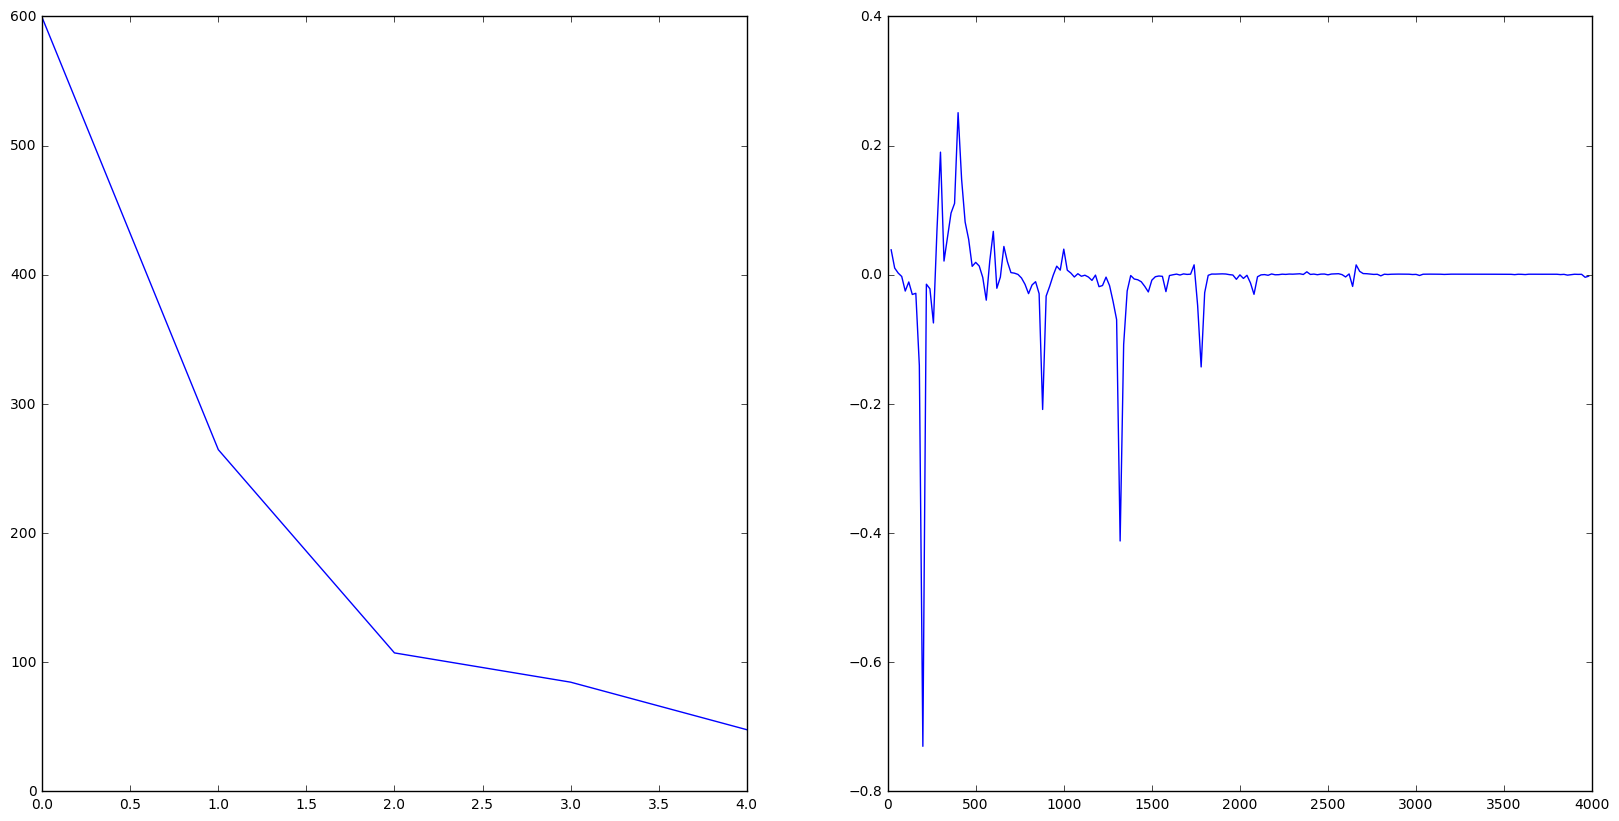

In [526]:
lowSampler2.reset(offset=maxE6Index-5)
test = np.array([power(lowSampler2.reset(lowSampler2.offset+10)[frequencyRange]) for i in range(400)])

U_k, S_k = more_efficient_eigenfaces2(test, 5)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(S_k)
plt.subplot(1,2,2)
plt.plot(lowSampler2.frequencies[frequencyRange], U_k[:,0])
plt.show()

Let's look at the violin plucking shape...

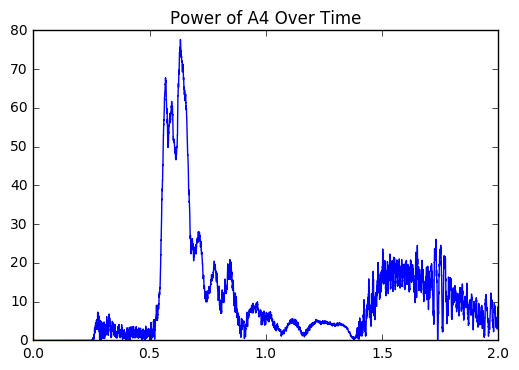

In [537]:
# A4 (440 Hz)

lowSampler2.reset()

indx440 = np.nonzero((lowSampler2.frequencies > 435) & (lowSampler2.frequencies < 445))[0][0] # index of freq ~1319

A4PowerOverTime = power([lowSampler2.next()[indx440] for i in range(oneSec*2)])

plt.plot(np.linspace(0,2,oneSec*2,endpoint=False),A4PowerOverTime)
plt.title("Power of A4 Over Time")
plt.show()

max A4 power at 0.632857142857 seconds


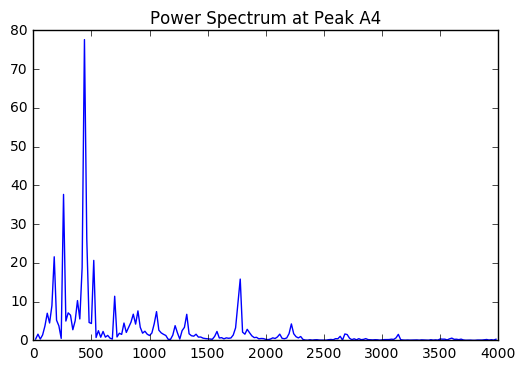

In [536]:
maxA4Index = np.argmax(A4PowerOverTime)

print "max A4 power at " + str(maxA4Index*1./Fs) + " seconds"

lowSampler2.reset(offset=maxA4Index-5)
averagedShape = np.mean([power(lowSampler2.next()[frequencyRange]) for i in range(10)], axis=0)

plt.plot(lowSampler2.frequencies[frequencyRange], averagedShape)
plt.title("Power Spectrum at Peak A4")
plt.show()

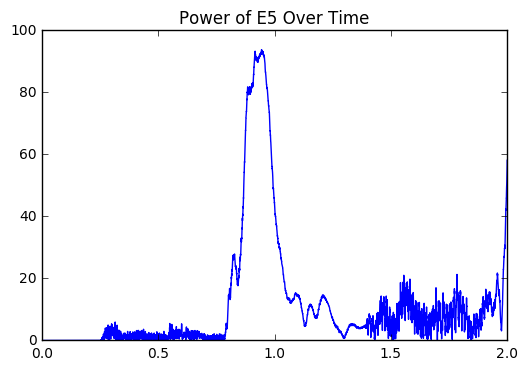

In [532]:
# E5 (660 Hz)

lowSampler2.reset()

indx660 = np.nonzero((lowSampler2.frequencies > 655) & (lowSampler2.frequencies < 665))[0][0] # index of freq ~1319

E5PowerOverTime = power([lowSampler2.next()[indx660] for i in range(oneSec*2)])

plt.plot(np.linspace(0,2,oneSec*2,endpoint=False),E5PowerOverTime)
plt.title("Power of E5 Over Time")
plt.show()

max E5 power at 0.943628117914 seconds


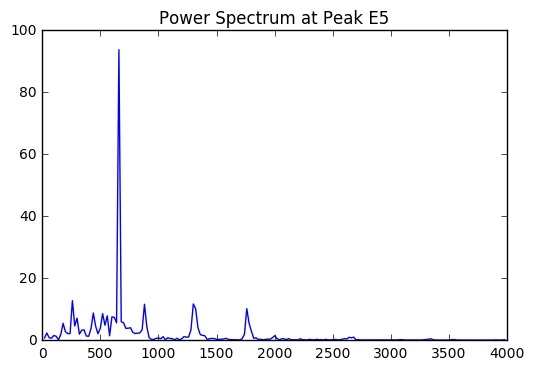

In [535]:
maxE5Index = np.argmax(E5PowerOverTime)

print "max E5 power at " + str(maxE5Index*1./Fs) + " seconds"

lowSampler2.reset(offset=maxE5Index-5)
averagedShape = np.mean([power(lowSampler2.next()[frequencyRange]) for i in range(10)], axis=0)

plt.plot(lowSampler2.frequencies[frequencyRange], averagedShape)
plt.title("Power Spectrum at Peak E5")
plt.show()

hmm, the violin pluckings look rather similar

let me try subtracting from the average waveform before it to see how it looks
but in order to figure out what is part of the spike, and what isn't, we need to use a grouping algorithm
we could also take into account bpm, aka how long each note should be, and never exceed that

In [ ]:

print "max A4 power at " + str(maxA4Index*1./Fs) + " seconds"

lowSampler2.reset(offset=maxA4Index-5)
averagedShape = np.mean([power(lowSampler2.next()[frequencyRange]) for i in range(10)], axis=0)

averageUpToMaxA4 = np.mean([power(lowSampler2.next()[frequencyRange]) for i in range(int(Fs/10))], axis=0)

plt.plot(lowSampler2.frequencies[frequencyRange], averagedShape)
plt.show()

D3 (147), E3 (165)

200


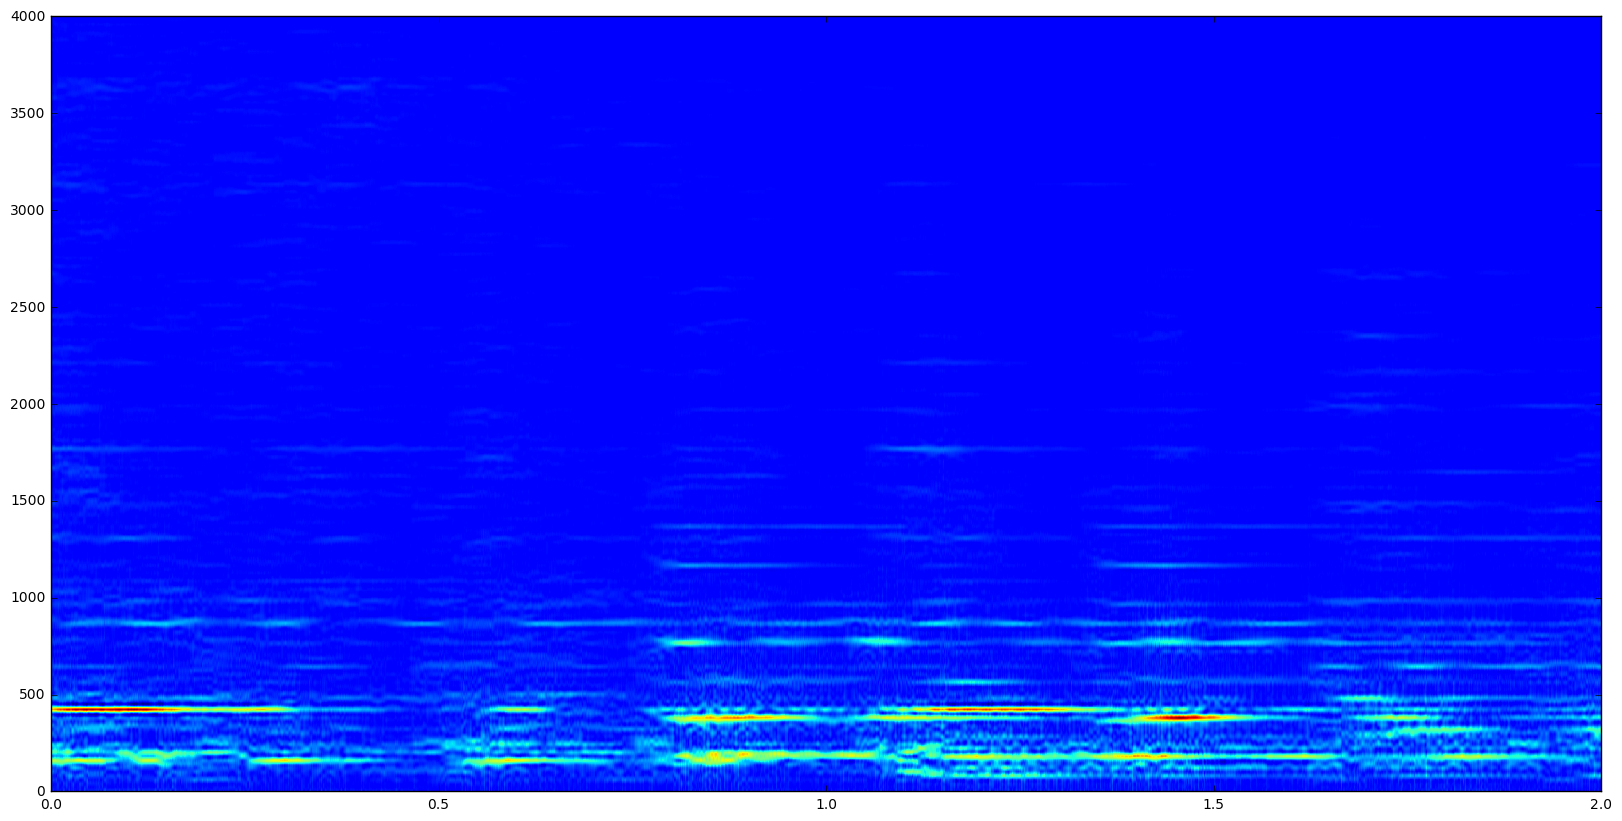

In [561]:
sakaeEnd = rawsakae1[156*Fs:(156+5)*Fs]
lowSamplerEnd = DominantFrequencySampler(sakaeEnd, Fs/20)

freqCrop = len(first_half(lowSampler2.frequencies)[first_half(lowSamplerEnd.frequencies) < 4000])
print freqCrop
average_over = 10 # average the data over 10 samples
spectrum = np.zeros((int(oneSec*2/average_over), freqCrop))
for i in range(int(oneSec*2/average_over)):
    spectrum[i] = np.mean([power(first_half(lowSamplerEnd.next())[:freqCrop]) for j in range(average_over)], axis=0)

plt.figure(figsize=(20,10))
spectrum = interpolation.zoom(spectrum, [1,10])
plt.imshow(spectrum.T, aspect='auto', interpolation='none', extent=[0,2,4000,0]) #np.linspace(0,2,oneSec*2,endpoint=False),
#plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

In [563]:
Audio(sakaeEnd[:2*Fs], rate=Fs)

100


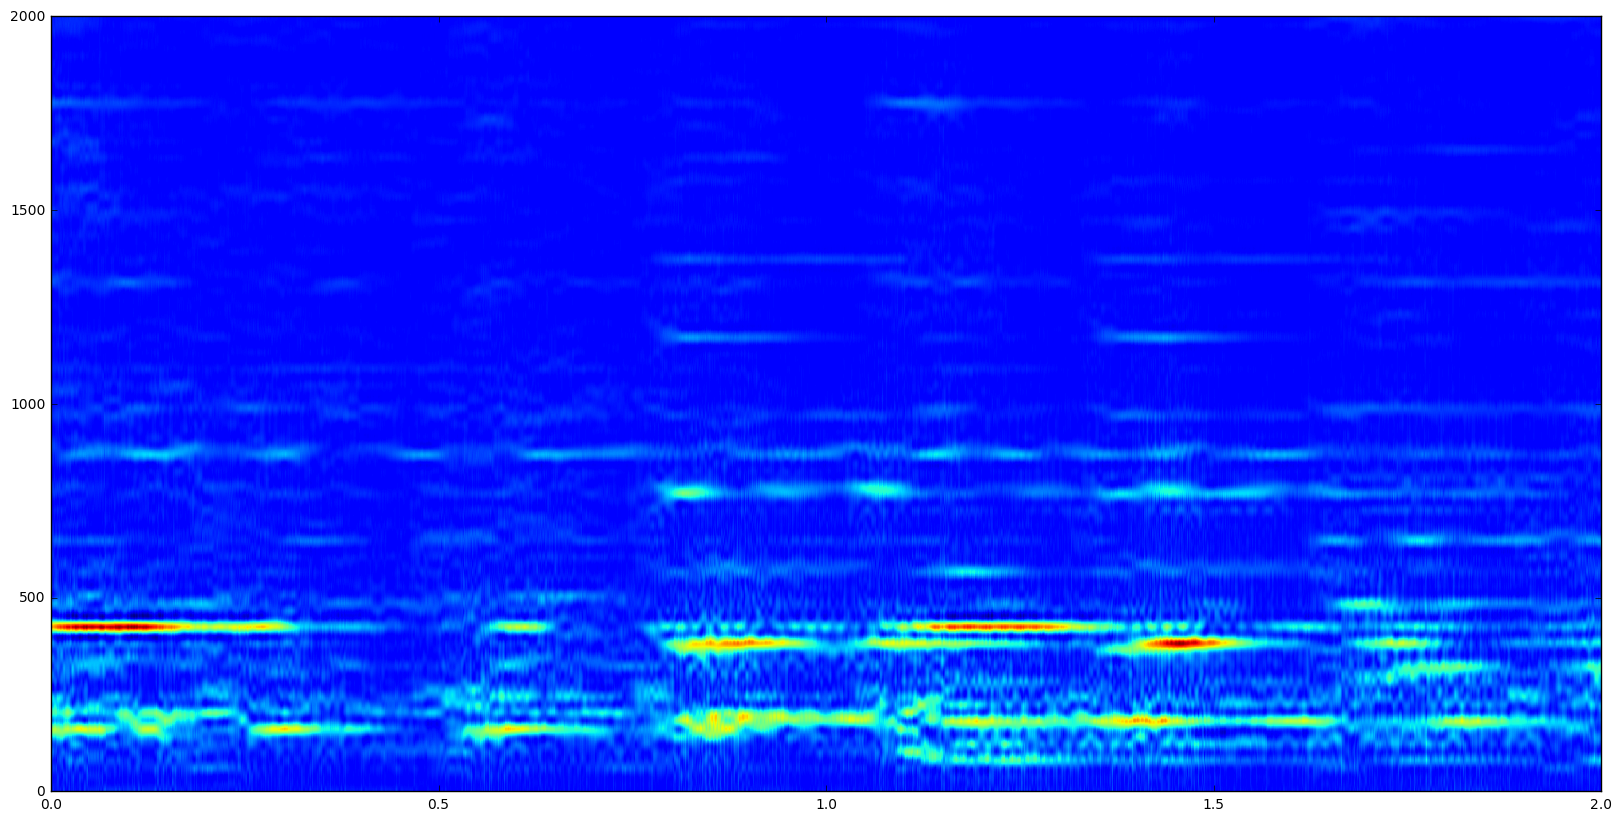

In [576]:
sakaeEnd = rawsakae1[156*Fs:(156+5)*Fs]
lowSamplerEnd = DominantFrequencySampler(sakaeEnd, Fs/20)

freqCrop = len(first_half(lowSampler2.frequencies)[first_half(lowSamplerEnd.frequencies) < 2000])
print freqCrop
average_over = 5 # average the data over 10 samples
spectrum = np.zeros((int(oneSec*2/average_over), freqCrop))
for i in range(int(oneSec*2/average_over)):
    spectrum[i] = np.mean([power(first_half(lowSamplerEnd.next())[:freqCrop]) for j in range(average_over)], axis=0)

plt.figure(figsize=(20,10))
spectrum = interpolation.zoom(spectrum, [1,20])
plt.imshow(spectrum.T, aspect='auto', interpolation='none', extent=[0,2,2000,0]) #np.linspace(0,2,oneSec*2,endpoint=False),
#plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

50


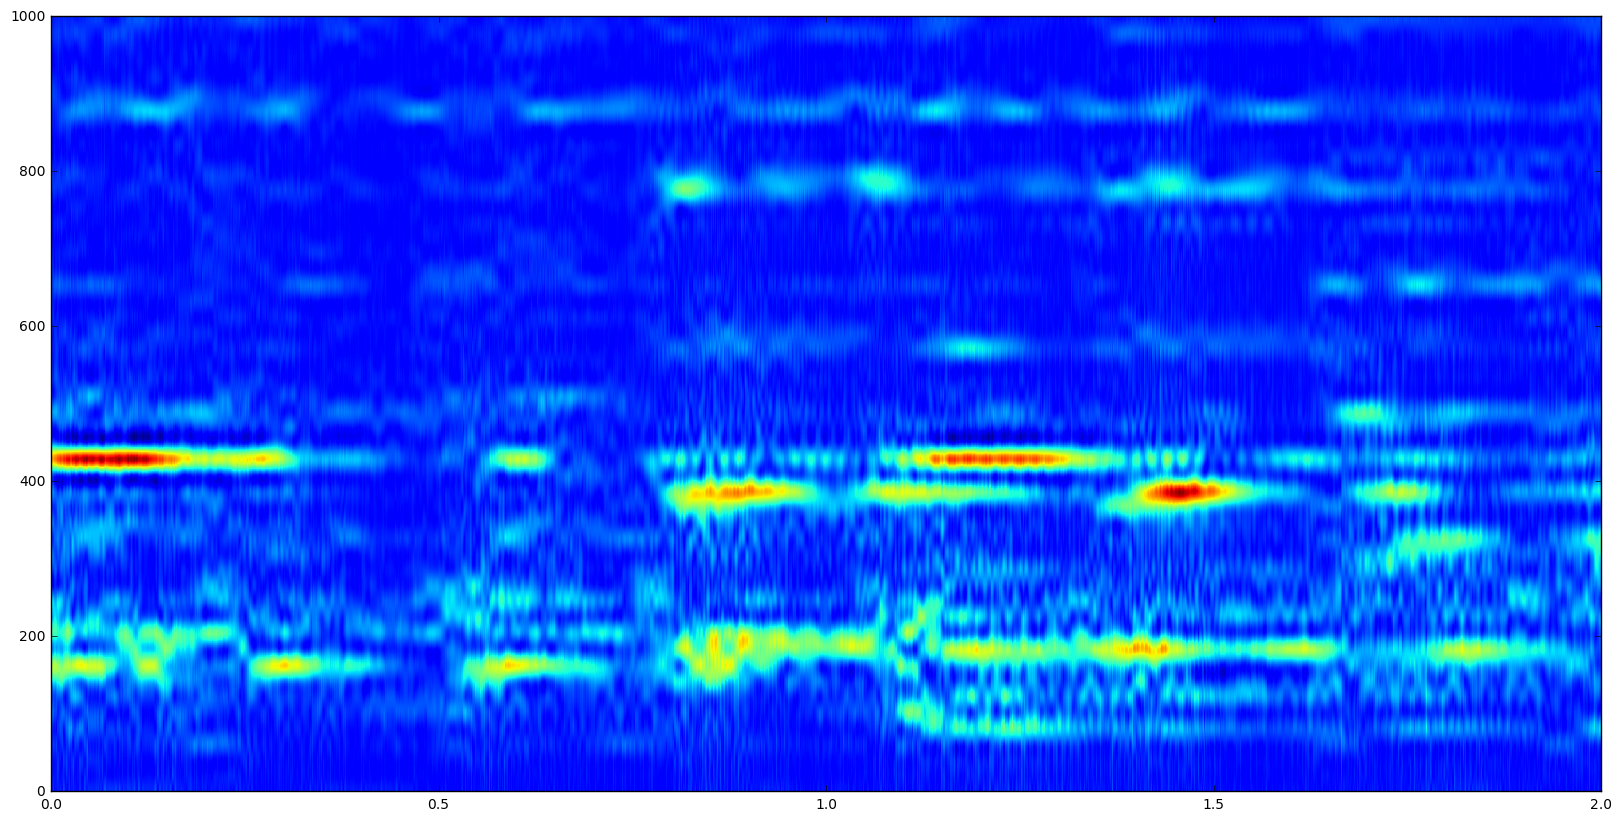

In [577]:
sakaeEnd = rawsakae1[156*Fs:(156+5)*Fs]
lowSamplerEnd = DominantFrequencySampler(sakaeEnd, Fs/20)

freqCrop = len(first_half(lowSampler2.frequencies)[first_half(lowSamplerEnd.frequencies) < 1000])
print freqCrop
average_over = 5 # average the data over 10 samples
spectrum = np.zeros((int(oneSec*2/average_over), freqCrop))
for i in range(int(oneSec*2/average_over)):
    spectrum[i] = np.mean([power(first_half(lowSamplerEnd.next())[:freqCrop]) for j in range(average_over)], axis=0)

plt.figure(figsize=(20,10))
spectrum = interpolation.zoom(spectrum, [1,40])
plt.imshow(spectrum.T, aspect='auto', interpolation='none', extent=[0,2,1000,0]) #np.linspace(0,2,oneSec*2,endpoint=False),
#plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

In [39]:
sakaeClash = rawsakae1[154*Fs:(154+5)*Fs]
Audio(sakaeClash[:2*Fs], rate=Fs)

100


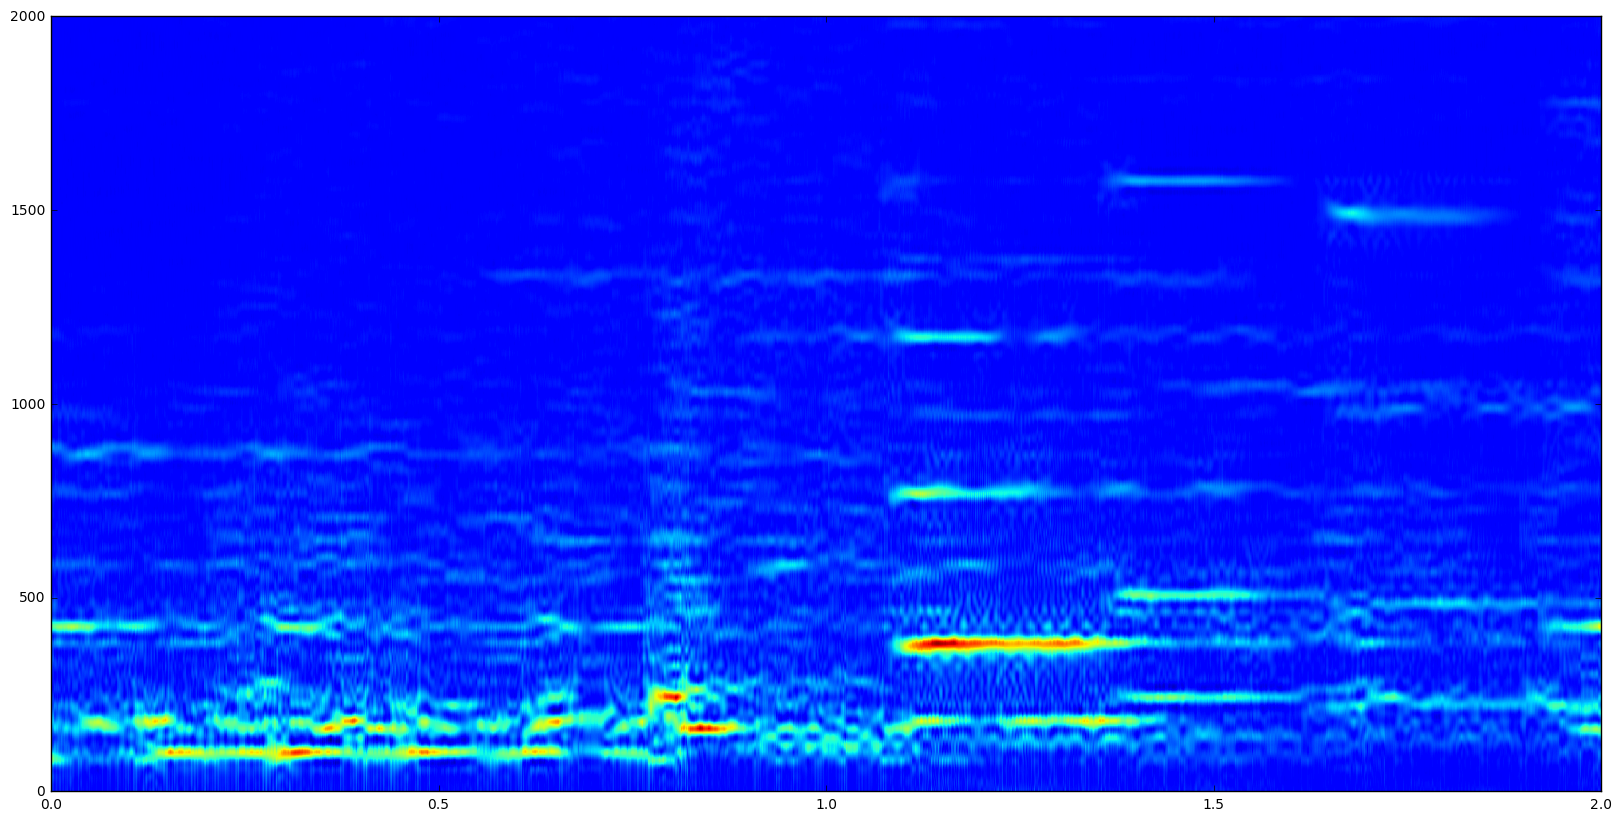

In [40]:
lowClashSampler = DominantFrequencySampler(sakaeClash, Fs/20)

freqCrop = len(first_half(lowClashSampler.frequencies)[first_half(lowClashSampler.frequencies) < 2000])
print freqCrop
average_over = 5 # average the data over 10 samples
spectrum = np.zeros((int(oneSec*2/average_over), freqCrop))
for i in range(int(oneSec*2/average_over)):
    spectrum[i] = np.mean([power(first_half(lowClashSampler.next())[:freqCrop]) for j in range(average_over)], axis=0)

plt.figure(figsize=(20,10))
spectrum = interpolation.zoom(spectrum, [1,20])
plt.imshow(spectrum.T, aspect='auto', interpolation='none', extent=[0,2,2000,0]) #np.linspace(0,2,oneSec*2,endpoint=False),
#plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

200


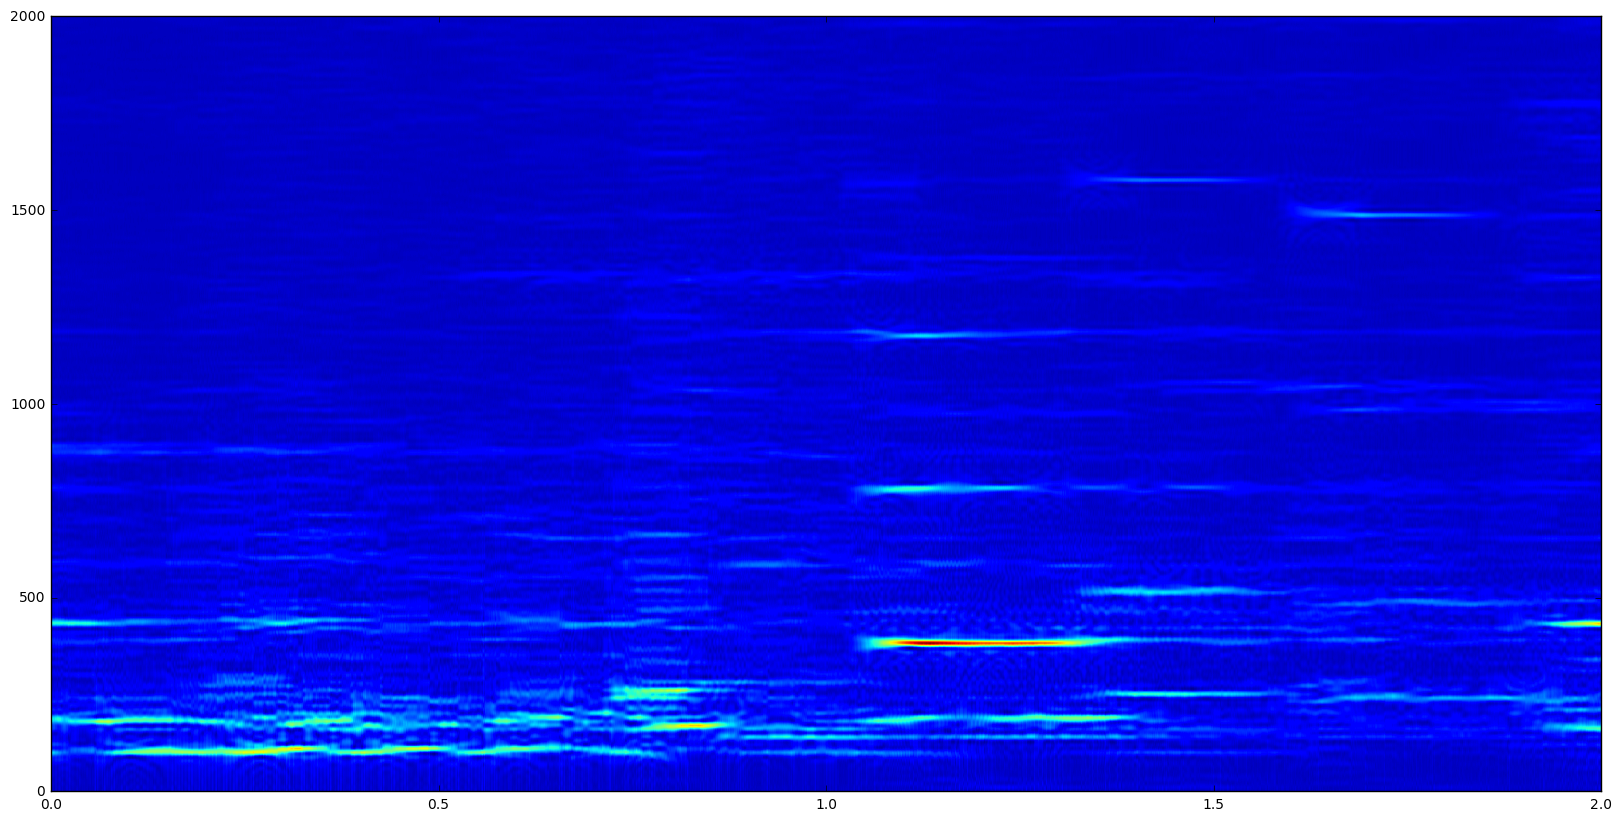

In [590]:
lowerClashSampler = DominantFrequencySampler(sakaeClash, Fs/10)

freqCrop = len(first_half(lowerClashSampler.frequencies)[first_half(lowerClashSampler.frequencies) < 2000])
print freqCrop
average_over = 5 # average the data over 10 samples
spectrum = np.zeros((int(oneSec*2/average_over), freqCrop))
for i in range(int(oneSec*2/average_over)):
    spectrum[i] = np.mean([power(first_half(lowerClashSampler.next())[:freqCrop]) for j in range(average_over)], axis=0)

plt.figure(figsize=(20,10))
spectrum = interpolation.zoom(spectrum, [1,20])
plt.imshow(spectrum.T, aspect='auto', interpolation='none', extent=[0,2,2000,0]) #np.linspace(0,2,oneSec*2,endpoint=False),
#plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

100


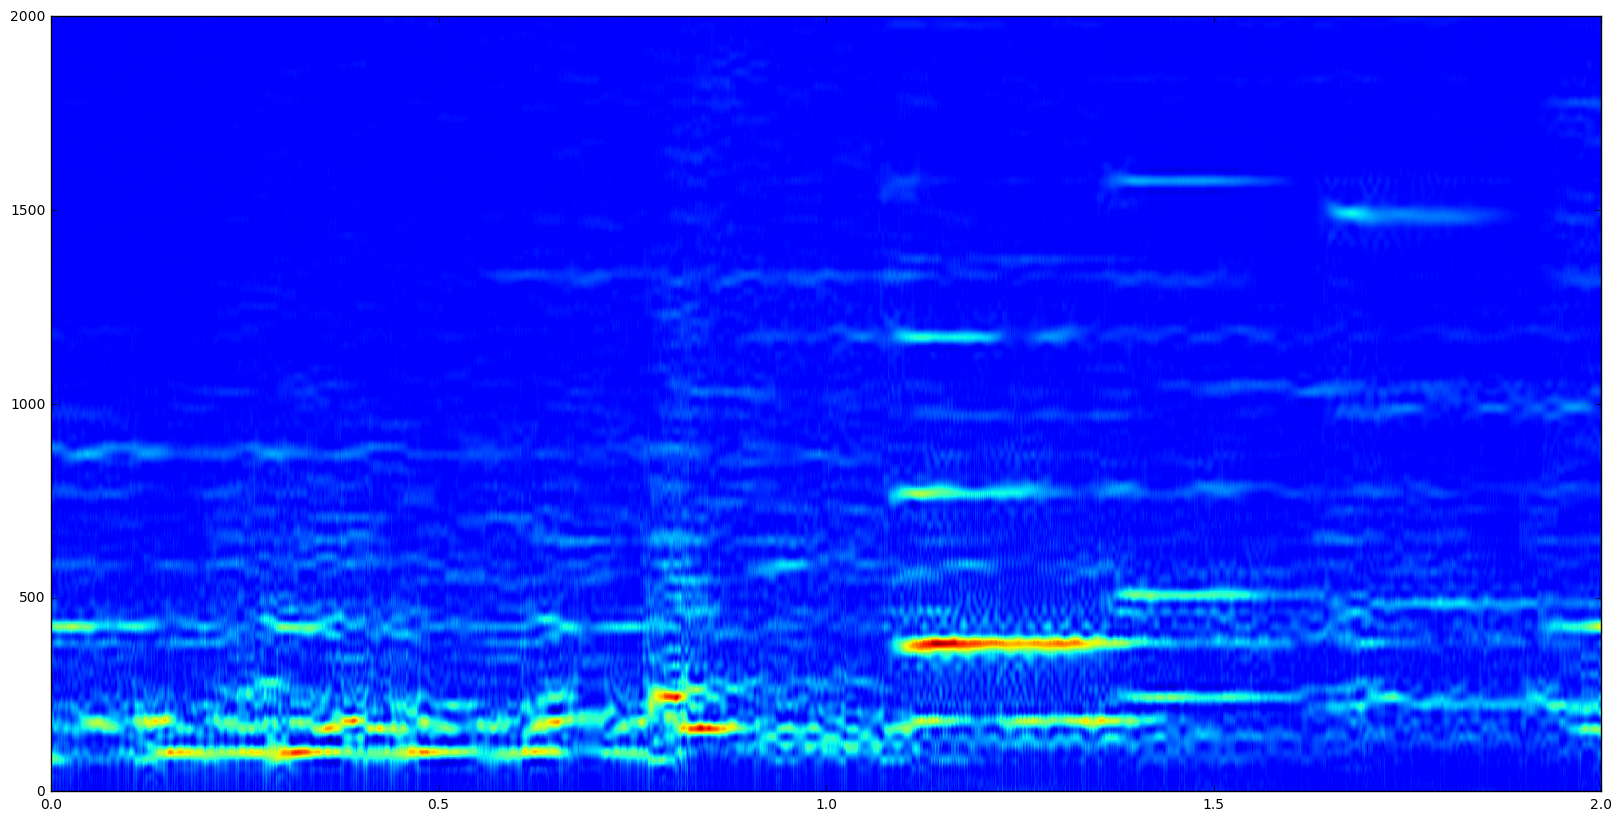

In [41]:
lowClashSampler = DominantFrequencySampler(sakaeClash, Fs/20)

freqCrop = len(first_half(lowClashSampler.frequencies)[first_half(lowClashSampler.frequencies) < 2000])
print freqCrop
average_over = 10 # average the data over 10 samples
spectrum = np.zeros((int(oneSec*2/average_over), freqCrop))
for i in range(int(oneSec*2/average_over)):
    spectrum[i] = np.mean([power(first_half(lowClashSampler.next())[:freqCrop]) for j in range(average_over)], axis=0)

plt.figure(figsize=(20,10))
spectrum = interpolation.zoom(spectrum, [1,20])
plt.imshow(spectrum.T, aspect='auto', interpolation='none', extent=[0,2,2000,0]) #np.linspace(0,2,oneSec*2,endpoint=False),
#plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

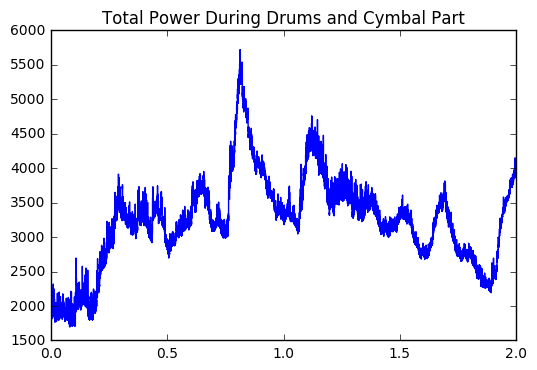

In [42]:
lowClashSampler.reset()

totalPowerOverTime = np.array([np.sum(power(first_half(lowClashSampler.next())[:-1])) for i in range(oneSec*2)])

plt.plot(np.linspace(0, 2, oneSec*2), totalPowerOverTime)
plt.title("Total Power During Drums and Cymbal Part")
plt.show()

there's a clear spike in the power graph that coincides with the main drum/cymbal clash, even though its not as visible in the spectrogram. Probably because the power is spread out over many different frequencies. Notice that the first piano note has some residual after-spikes. In order to filter theres out, we could keep track of the last recorded note, and check how different each sample is from that note. When the power of the difference exceeds the average difference power (averaged over a long time), then we record it as a new note, and wait until that note "peaks", and measure the shape at that moment.

We should also have this "average difference power" should decay over time in case the song changes volume suddenly (up to a limit, don't want it to decay all the way to zero or else we'd start recording noise as notes)

(For more accurate version of this, perhaps we can examine how the last note is decaying as well, as well as keep track of multiple last notes in case there are multiple notes still lingering in parallel)

First, lets look at the shape of the drum/cymbal clash. This is a little difficult to do using the same method we were using before, because there is no clear "note", or frequency, of the clash. Instead, we look for the peak in the total power graph.

Clash happens at 0.805714285714 seconds


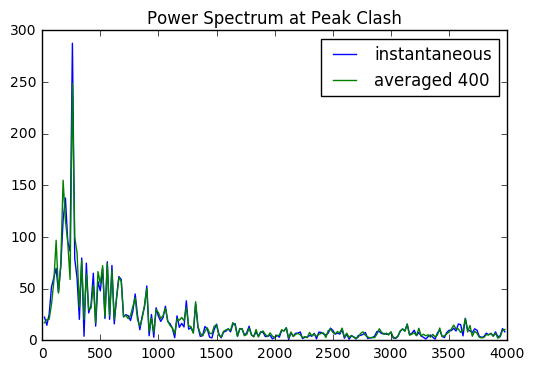

In [604]:
clashTime = np.argmax(totalPowerOverTime)
print "Clash happens at " + str(clashTime*1./Fs) + " seconds"
clashPowerSpectrum = power(lowClashSampler.reset(offset=clashTime)[frequencyRange])

lowClashSampler.reset(offset=clashTime)
averagedClashPowerSpectrum = np.mean([power(lowClashSampler.next()[frequencyRange]) for i in range(400)], axis=0)

plt.hold(True)
plt.plot(lowSampler2.frequencies[frequencyRange], clashPowerSpectrum, label="instantaneous")
plt.plot(lowSampler2.frequencies[frequencyRange], averagedClashPowerSpectrum, label="averaged 400")
plt.title("Power Spectrum at Peak Clash")
plt.legend()
plt.show()
plt.hold(False)

maybe we can use a clustering algorithm to group frequencies into the same instrument,
just in case some frequencies come a little later and some come a little earlier.

In [43]:
lowerClashSampler.reset()

totalPowerOverTime = np.array([np.sum(power(first_half(lowerClashSampler.next())[:-1])) for i in range(oneSec*2)])

plt.plot(np.linspace(0, 2, oneSec*2), totalPowerOverTime)
plt.title("Total Power During Drums and Cymbal Part")
plt.show()

NameError: name 'lowerClashSampler' is not defined

Clash happens at 0.805714285714 seconds


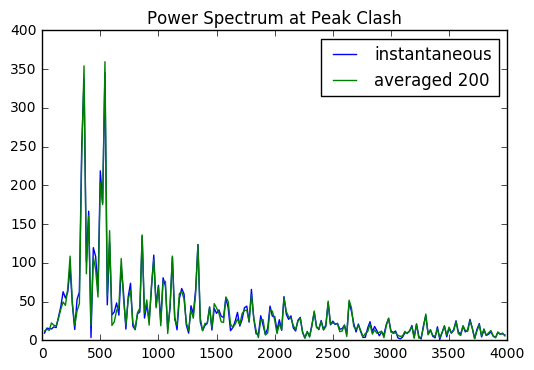

In [600]:
clashTime = np.argmax(totalPowerOverTime)
print "Clash happens at " + str(clashTime*1./Fs) + " seconds"
clashPowerSpectrum = power(lowerClashSampler.reset(offset=clashTime)[frequencyRange])

lowerClashSampler.reset(offset=clashTime)
averagedClashPowerSpectrum = np.mean([power(lowerClashSampler.next()[frequencyRange]) for i in range(200)], axis=0)

plt.hold(True)
plt.plot(lowSampler2.frequencies[frequencyRange], clashPowerSpectrum, label="instantaneous")
plt.plot(lowSampler2.frequencies[frequencyRange], averagedClashPowerSpectrum, label="averaged 200")
plt.title("Power Spectrum at Peak Clash")
plt.legend()
plt.show()
plt.hold(False)

## Resolution

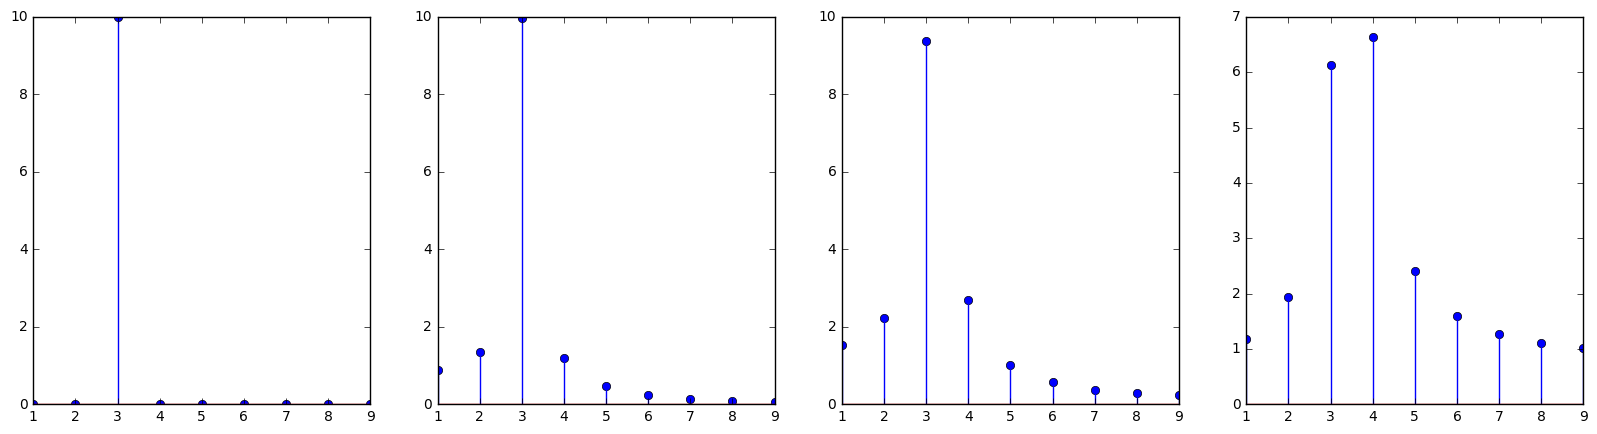

In [631]:
frames = 20
hz3 = power(first_half(np.fft.fft(tone(3, t=1, Fs=frames)))[:-1])
hz3_125 = power(first_half(np.fft.fft(tone(3.125, t=1, Fs=frames)))[:-1])
hz3_25 = power(first_half(np.fft.fft(tone(3.25, t=1, Fs=frames)))[:-1])
hz3_5 = power(first_half(np.fft.fft(tone(3.5, t=1, Fs=frames)))[:-1])
freqs = first_half(frequencies(range(frames),frames))[:-1]

plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.stem(freqs,hz3)
plt.subplot(1,4,2)
plt.stem(freqs,hz3_125)
plt.subplot(1,4,3)
plt.stem(freqs,hz3_25)
plt.subplot(1,4,4)
plt.stem(freqs,hz3_5)
plt.show()

In [ ]:
notice: the further the sample is from the 

[ 1.  2.  3.  4.  5.  6.  7.  8.  9.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9.]
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.]
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.]
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.]
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.]


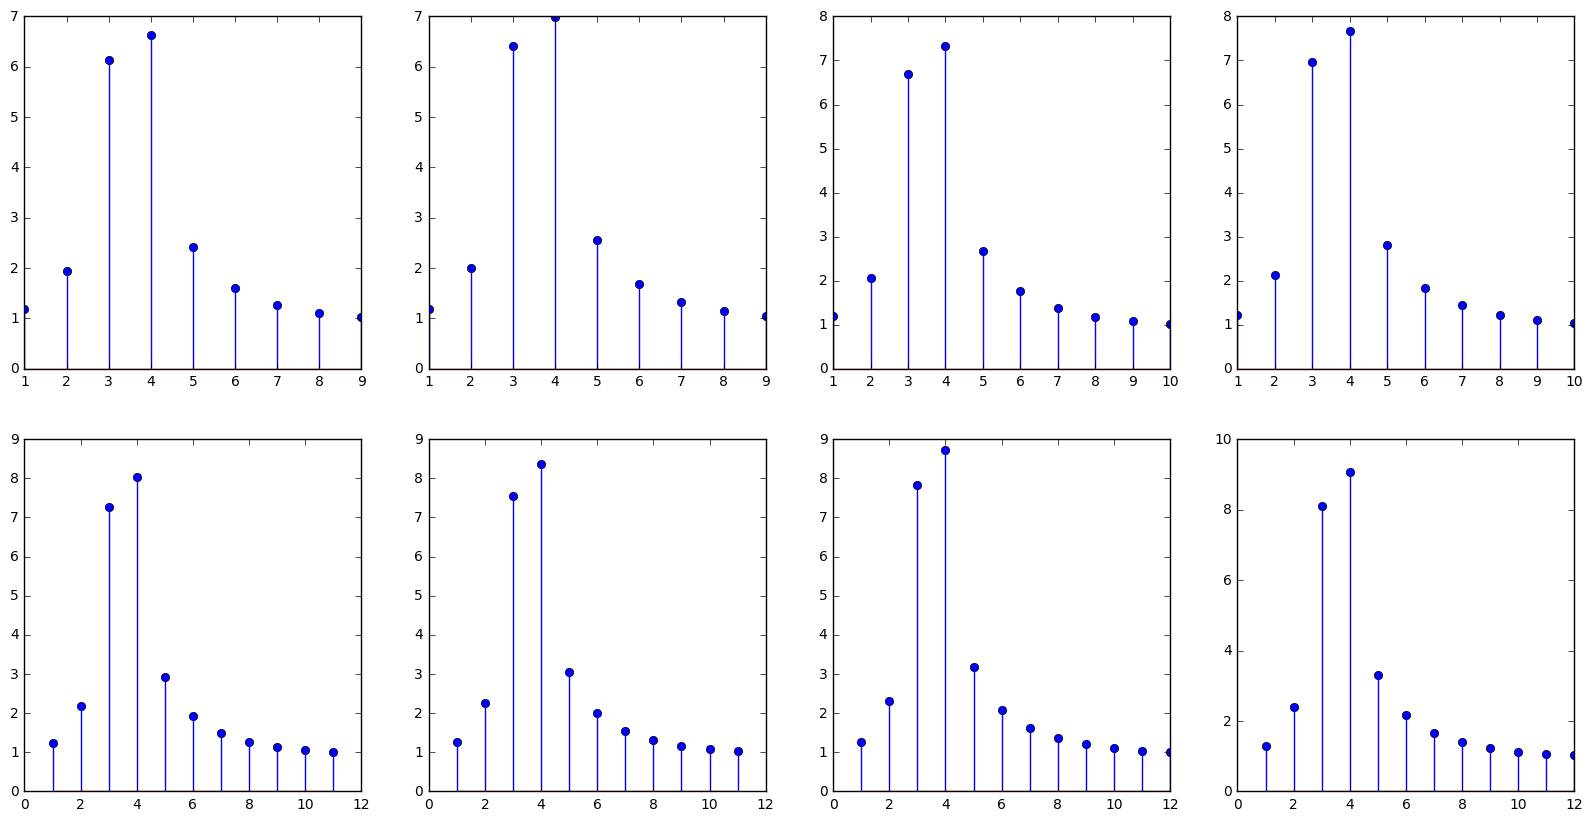

In [624]:
plt.figure(figsize=(20,10))
for frames in range(20,28):
    hz3_5 = power(first_half(np.fft.fft(tone(3.5, t=1, Fs=frames)))[:-1])
    freqs = first_half(frequencies(range(frames),frames))[:-1]
    print freqs
    plt.subplot(2, 4, frames-19)
    plt.stem(freqs, hz3_5)
plt.show()

increasing sampling rate does not change resolution, only increases range. Lowest frequency (and also interval between frequencies) stays the same, highest frequency increases.

[ 1.  2.  3.  4.  5.  6.  7.  8.  9.]
[ 0.95  1.91  2.86  3.82  4.77  5.73  6.68  7.64  8.59  9.55]
[  0.92   1.83   2.75   3.67   4.58   5.5    6.42   7.33   8.25   9.17
  10.08]
[  0.88   1.77   2.65   3.54   4.42   5.31   6.19   7.08   7.96   8.85
   9.73  10.62]
[  0.86   1.71   2.57   3.43   4.29   5.14   6.     6.86   7.71   8.57
   9.43  10.29  11.14]
[  0.81   1.61   2.42   3.23   4.03   4.84   5.65   6.45   7.26   8.06
   8.87   9.68  10.48  11.29]
[  0.79   1.58   2.36   3.15   3.94   4.73   5.52   6.3    7.09   7.88
   8.67   9.45  10.24  11.03  11.82]
[  0.75   1.5    2.25   3.     3.75   4.5    5.25   6.     6.75   7.5
   8.25   9.     9.75  10.5   11.25  12.    12.75]


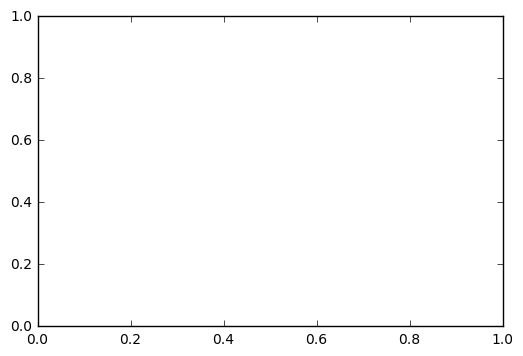

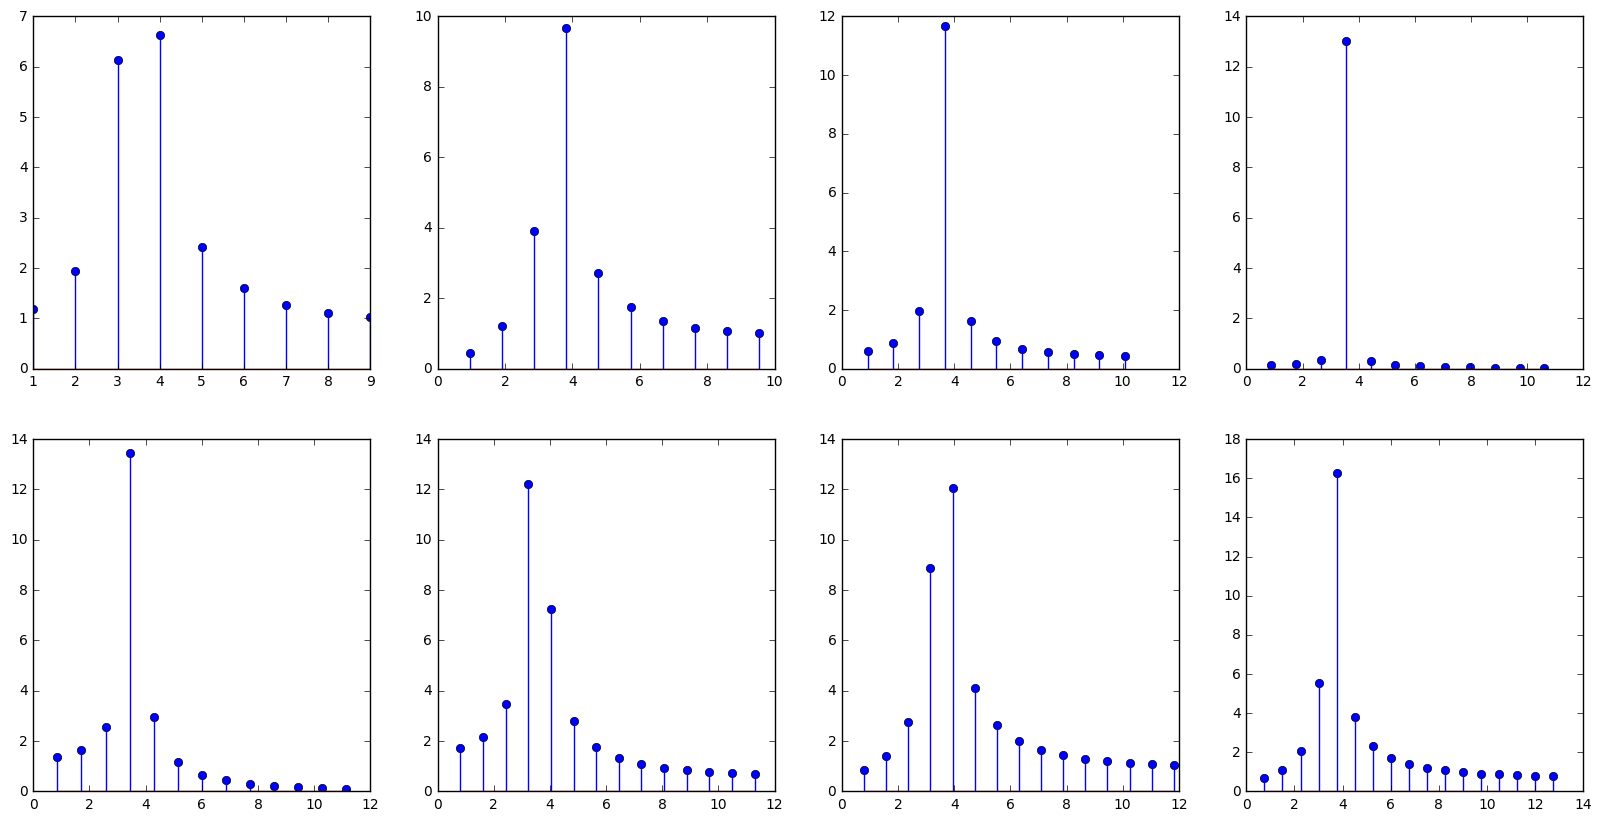

In [646]:
plt.figure(figsize=(20,10))
for frames in range(20,28):
    _ = np.fft.fft(tone(3.5, t=frames/20., Fs=frames))
    hz3_5 = power(first_half(_)[:-1])
    freqs = first_half(frequencies(range(len(_)),frames))[:-1]
    print np.round(freqs, decimals=2)
    plt.subplot(2, 4, frames-19)
    plt.stem(freqs, hz3_5)
plt.show()

increasing number of samples increases resolution, range stays the same. Lowest frequency (and also interval between frequencies) decreases, highest frequency stays the same.

Again, tradeoff between large sample size (which starts to capture external frequencies) and small sample size (smaller resolution). Perhaps there is a way to optimize the sample size for a certain frequency, to "tune" the sample size to that frequency? Or perhaps we can use an averaging mechanism to reduce external frequency influence for large sample sizes?

I don't have time for this >.<

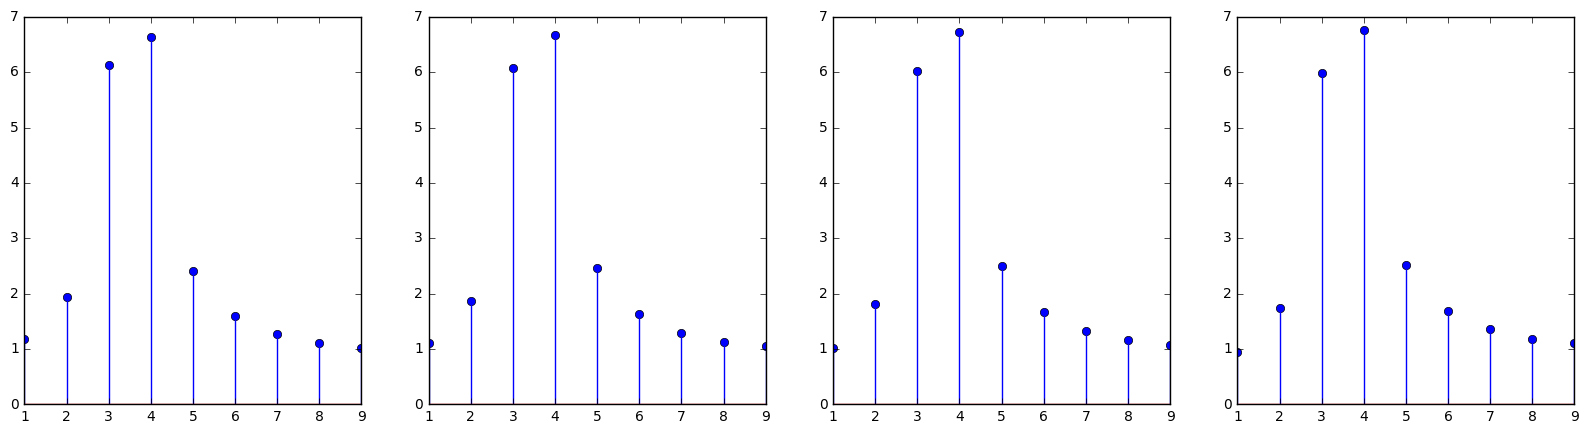

In [643]:
frames = 20
freqs = first_half(frequencies(range(frames),frames))[:-1]

plt.figure(figsize=(20,5))
for i in range(4):
    hz3_5 = power(first_half(np.fft.fft(tone(3.5, t=1, Fs=frames, angle=i*1./frames)))[:-1])
    plt.subplot(1,4,i+1)
    plt.stem(freqs,hz3_5)
plt.show()

Shifting phase by t/Fs doesn't change anything, thus, averaging across a rolling sample won't increases our resolution.

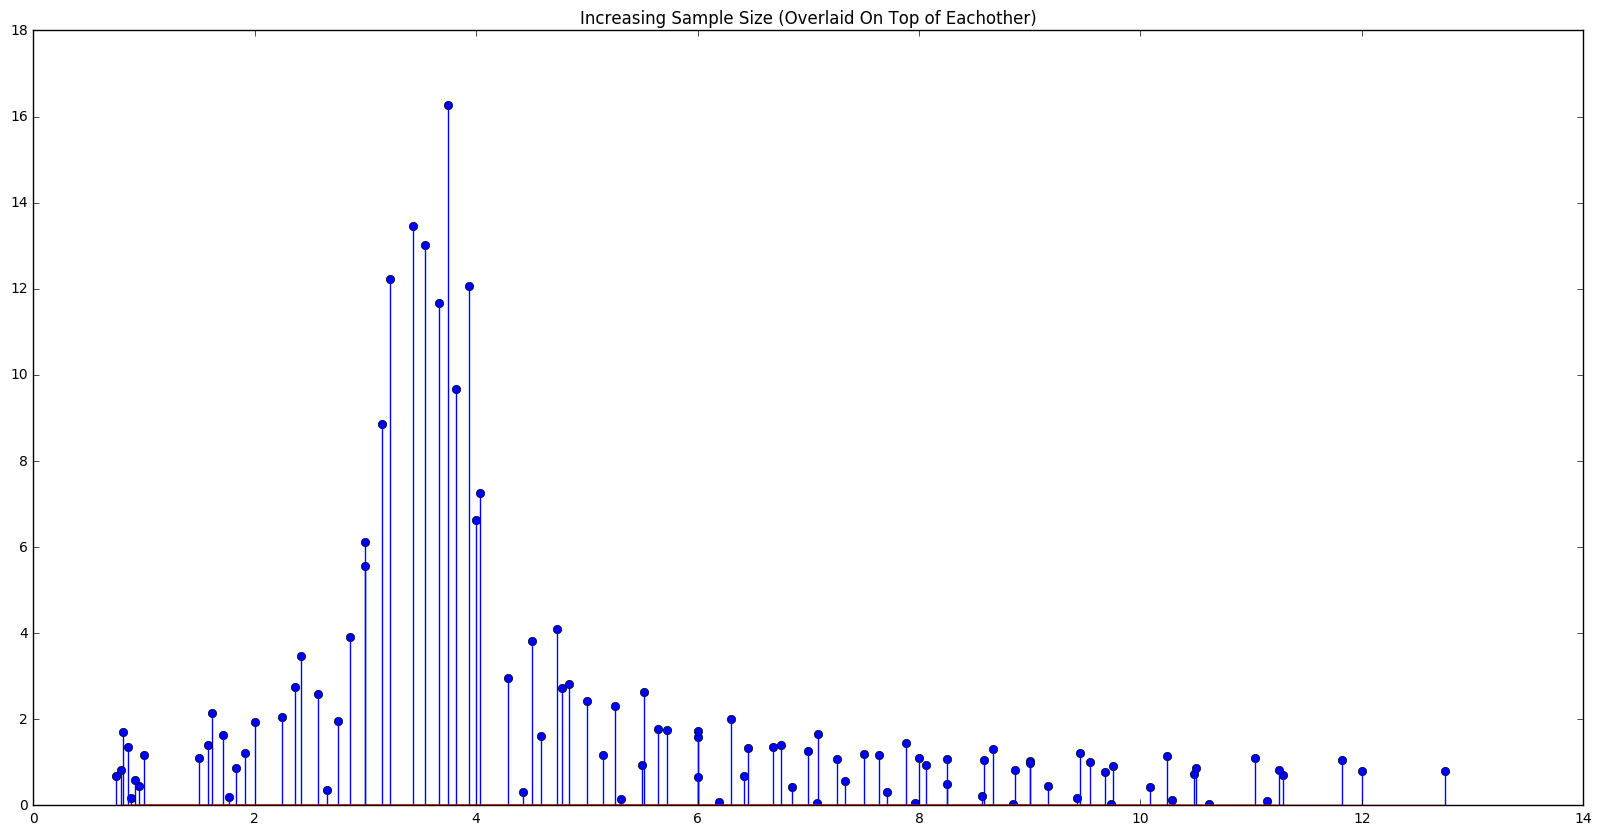

In [644]:
plt.figure(figsize=(20,10))
plt.hold(True)
for frames in range(20,28):
    tonefft = np.fft.fft(tone(3.5, t=frames/20., Fs=frames))
    hz3_5 = power(first_half(tonefft)[:-1])
    freqs = first_half(frequencies(range(len(tonefft)),frames))[:-1]
    plt.stem(freqs, hz3_5)
plt.title("Increasing Sample Size (Overlaid On Top of Eachother)")
plt.show()
plt.hold(False)

averaging across multiple sample sizes doesn't look like itl work either

## Difference Averaging

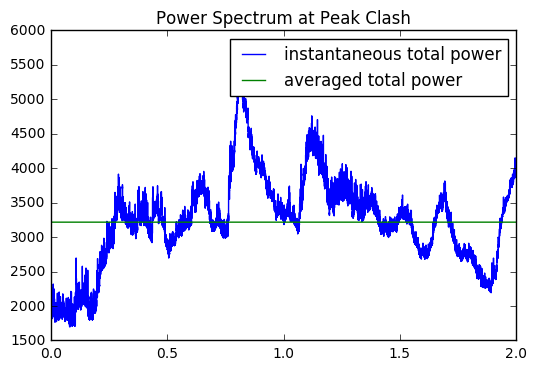

In [44]:
averagePower = np.sum(totalPowerOverTime)/(oneSec*2)

plt.hold(True)
plt.plot(np.linspace(0,2,oneSec*2,endpoint=False), totalPowerOverTime, label="instantaneous total power")
plt.plot(np.linspace(0,2,oneSec*2,endpoint=False), np.full(oneSec*2, averagePower), label="averaged total power")
plt.title("Power Spectrum at Peak Clash")
plt.legend()
plt.show()
plt.hold(False)

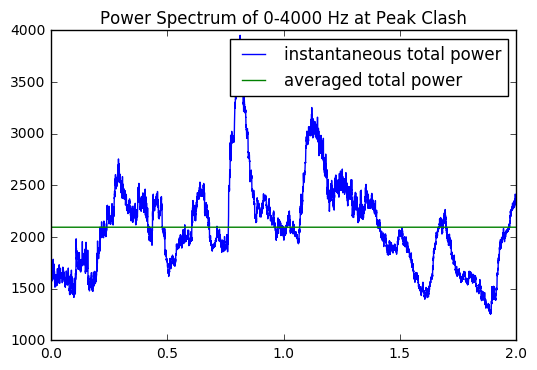

In [73]:
lowClashSampler.reset()

totalPowerOverTimeCropped = []
for i in range(oneSec*2):
    lowClashSampler.next()
    totalPowerOverTimeCropped = np.append(totalPowerOverTimeCropped, np.sum(power(lowClashSampler.dft[frequencyRange])))

#totalPowerOverTimeCropped = np.array([np.sum(power(lowClashSampler.next()[frequencyRange])) for i in range(oneSec*2)])
averagePowerCropped = np.mean(totalPowerOverTimeCropped)

plt.hold(True)
plt.plot(np.linspace(0,2,oneSec*2,endpoint=False), totalPowerOverTimeCropped, label="instantaneous total power")
plt.plot(np.linspace(0,2,oneSec*2,endpoint=False), np.full(oneSec*2, averagePowerCropped), label="averaged total power")
plt.title("Power Spectrum of 0-4000 Hz at Peak Clash")
plt.legend()
plt.show()
plt.hold(False)

In [75]:
# perhaps later I can fine tune this. For example, if there's a constant bass in the background, we still want to
# register the smaller notes on top, but we don't want to register too much (eg noise).
# maybe averaging total power over 1 second will take care of that
averageDifference = averagePowerCropped

lastNote = np.zeros(len(frequencyRange[0]))
lastNotePower = power(lastNote)
lastNoteIndex = 0
currNoteIndex = 0

lowClashSampler.reset()

for i in range(oneSec*2):
    powerDifference = power(lowClashSampler.next()[frequencyRange]) - lastNotePower
    total = np.sum(powerDifference.clip(min=0))
    if (total > averageDifference):
        currNoteIndex = i
        break

print "first note at " + str(currNoteIndex*1./Fs) + " seconds"

first note at 0.210793650794 seconds


In [77]:
# we could potentially find the dominant frequencies in difference, and then track when those frequencies peak,
# and then find the instrument shape from there. For now, lets just take when the difference>averagePower, and then
# average over a couple samples. Actually this won't work because we need to find the peak of this note to optimize
# finding the next note

def getDominantFrequencies(dft, frequencies, n=5):
    power_half = power(first_half(dft)[:-1]) # exclude the last frequency, because it *could* be the lowest negative freq
    top_powers = np.argpartition(power_half, -n)[-n:] # use argpartition to get indices of top n frequencies
    top_powers = top_powers[np.argsort(power_half[top_powers])][::-1] # sort the top frequency indices in descending order
    top_freqs = frequencies[top_powers+1] # add 1 because power_half starts at index 1 (not 0)
    top_magnitudes = power_half[top_powers]
    top_phases = np.angle(dft[top_powers+1])
    return (top_freqs, top_magnitudes, top_phases, top_powers+1)

freqs = frequencies(lastNote, Fs)
top_freqs, _, _, top_freqs_indices = getDominantFrequencies(lastNote, freqs)

In [79]:
# to find where it peaks, take an average slope for around 0.1 seconds, and then ...

# another way: record current power of dominant frequencies, and record when dominant frequencies dip below that. Then
# take the maximum in that time range

print currNoteIndex

startPower = np.sum(power(lowClashSampler.dft[top_freqs_indices]))
print startPower
currPower = np.sum(power(lowClashSampler.next()[top_freqs_indices]))
peakCurrNote = None
peakCurrNoteIndex = currNoteIndex
peakPower = currPower
while (currPower >= startPower):
    if (currPower > peakPower):
        peakCurrNote = lowClashSampler.dft
        peakCurrNoteIndex = lowClashSampler.offset
    currPower = np.sum(power(lowClashSampler.next()[top_freqs_indices]))

print peakCurrNoteIndex
print peakCurrNoteIndex - currNoteIndex

9296
77.8846604489
9296
0


In [64]:
plt.hold(True)
plt.plot(lowSampler2.frequencies[frequencyRange], clashPowerSpectrum, label="instantaneous")
plt.plot(lowSampler2.frequencies[frequencyRange], averagedClashPowerSpectrum, label="averaged 200")
plt.title("Power Spectrum at Peak Clash")
plt.legend()
plt.show()
plt.hold(False)

NameError: name 'clashPowerSpectrum' is not defined